# Georreferencia fotos

## Introducción

Ya tenemos las fotos correctamente orientadas. Lo siguiente que necesitamos es georreferenciar o posicionar correctamente en coordenadas terrestres (latitud, longitud) los píxeles de las fotos de manera que podamos añadir marcas sobre ellas para por ejemplo señalar ciudades.

El programa ejecutado en AstroPi ya nos proporciona directamente las coordenadas del punto central de cada foto, aunque como luego veremos, en realidad esas coordenadas incluyen un error sistemático al no estar la cámara perfectamente orientada al centro de la Tierra.

A partir de ese punto central de las fotos (convenientemente corregido) y calculando las dimensiones de los píxeles en distancia sobre la superficie de la Tierra a partir de las características de la óptica y de la altitud de la estación espacial, podremos por fin georreferenciar cada pixel de la foto.

## Resolución de las fotos

Lo primero que necesitamos es conocer el factor pixel/m de las fotos, es decir averiguar las dimensiones de las fotos en metros. Esto depende de las características de la óptica de la cámara de AstroPi y de la altura de la estación. [Esta web](https://www.3dflow.net/ground-sampling-distance-calculator/) nos ayuda a calcularlo. Por ejemplo para la foto 493, los parámetros son los siguientes:

* Image width (pixels): 3280
* Image height (pixels): 2464
* Focal lenght (mm): 5
* Sensor width (mm): 6.287
* Distance (d) in meters: 420980.87

![Ground sampling distance calculator](images/Ground_sampling_distance_calculator.png)

Como vemos el resultado es:

* GSD (cm/pixel): 16138.456
* Dw (m): 529341.346
* Dh (m): 397651.548

Necesitamos saber si el GSD obtenido será válido para todas las fotos. En los cálculos, el único dato que puede variar entre foto y foto es `d` es decir la altitud de la estación. Representando dicha altitud con el tiempo vemos que sí varía:

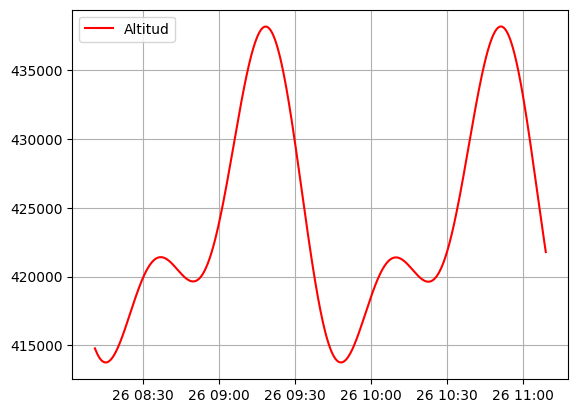

In [61]:
import os
import pandas
import matplotlib.pyplot as plt

# Defining some environment variables for data sources
path = os.path.dirname(os.path.realpath("__file__"))
RESULTS_FILE = "atlantes_2021-2022.csv"     

file = os.path.join(path, RESULTS_FILE)       # CSV input file complete path
data = pandas.read_csv(file, parse_dates=[0]) # Reading whole file

# Columns in file:
#    "datetime", "picture_file", "latitude", "longitude", "elevation", "temp_cpu", "temp_h", "temp_p",
#    "humidity", "pressure", "pitch", "roll", "yaw", "mag_x", "mag_y", "mag_z",
#    "accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"
data_x = data.datetime
data_y = data.elevation

fig, ax = plt.subplots()
ax.plot(data_x, data_y, label="Altitud", color="red")

plt.legend()                                  # Activating chart legend
plt.grid()                                    # Activating chart grid
plt.show()                                    # Showing the chart

Por tanto tenemos que aprender a hacer los cálculos que se hacen en la [web](https://www.3dflow.net/ground-sampling-distance-calculator/) que habíamos utilizado. El cálculo es una simple regla de tres:

$$
D_w = \frac{S_w * d}{F}
$$

Y el factor de conversión pixels/distancia se obtiene fácilmente dividiendo por la resolución de las fotos y convirtiendo los metros en centímetros:

$$
GSD = \frac{D_w * 100}{\textrm{Image width}} = \frac{S_w * d * 100}{F * \textrm{Image width}}
$$

Por ejemplo, el cálculo que habíamos hecho en la [web](https://www.3dflow.net/ground-sampling-distance-calculator/) se puede reproducir así:

$$
GSD = \frac{S_w * d * 100}{F * \textrm{Image width}} = \frac{6,287 * 420980,87 * 100}{5 * 3280} = 16138,456\;cm/px
$$

Las fotos tienen todas una resolución de 3280px de ancho y 2464px de alto. Por tanto la foto 493 de la que hemos hecho os cálculos cubrirá las siguientes distancias en horizontal y vertical:

$$
D_w =  \frac{\textrm{Image width} * GSD}{100 cm/m} = \frac{3280 * 16138,456}{100} = 529341 m = 529,34 km
$$
$$
D_h =  \frac{\textrm{Image height} * GSD}{100 cm/m} = \frac{2464 * 16138,456}{100} = 397652 m = 397,62 km
$$

## Corrección posición centro cámara

Otro efecto que hemos observado en las fotos es que lo que aparece en el centro no coincide con las coordenadas (latitud, longitud) asociadas a la foto. Esto es normal dado que los astronautas que colocan la AstroPi al empezar la captura de los datos no cuentan con un sistema de calibración que asegure que el eje de la cámara esté correctamente dirigido al centro de la Tierra. Así pues vamos a calcular la desviación para corregirla en nuestros cálculos posteriores. Será fundamental para superponer correctamente cualquier elemento como por ejemplo ciudades sobre las fotos.

Para ello elegiremos una foto que contenga exactamente en el centro un objeto fácilmente reconocible del terreno que nos permita relacionar sus coordenadas reales con las asociadas a la foto. La foto elegida es la 557 que muestra la costa de Somalia:

![557](images/atlantes_557_crosshair.jpg)

La posición de la foto capturada por el programa ejecutado en AstroPi y que teóricamente corresponde al punto central (que vemos marcado en la foto anterior) es (a este punto lo llamaremos I):

* Latitud: -1.388801
* Longitud: 42.051250

Localizamos ese punto central en un mapa real:

![557 real](images/atlantes_557_real.jpg)

Vemos que las coordenadas del punto central en realidad son (a este punto lo llamaremos O):

* Latitud: -0.921566
* Longitud: 41.995050

Vamos a suponer que el desplazamiento se mantiene constante en todas las fotos, por lo que deduciéndolo de la foto anterior nos servirá para corregirlas todas. Lo que vamos a calcular es la magnitud y el ángulo de la corrección que tendremos que efectuar a las coordenadas del punto central de cada foto. El problema es que el ángulo será constante en la orientación original de las fotos, pero sobre las fotos ya rotadas tendremos que tener en cuenta dicha rotación. No podemos trabajar con las fotos antes de la rotación ya que la librería [geopy](https://geopy.readthedocs.io/en/latest) que utilizamos para los cálculos solo puede trabajar con fotos/mapas correctamente orientadas, es decir con el norte arriba. Empezamos pues haciendo los cálculos de la magnitud de la desviación y su ángulo. Vamos a utilizar el típico triángulo rectángulo que utilizamos durante la orientación de las fotos para determinar distancia y ángulo entre dos puntos latitud/longitud.

En la foto siguiente vemos representados el punto que corresponde a la posición de la foto medida por AstroPi (I) y el de la posición central de la misma (O). 

![557 error](images/atlantes_557_crosshair_error.jpg)

Como vemos el error no es pequeño por lo que hay que tenerlo en cuenta o la representación de elementos sobre las fotos resultará demasiado imprecisa. Las coordenadas de los puntos I y O son las que hemos comentado antes, es decir:

* I: -1.388801, 42.051250
* O: -0.921566, 41.995050

Con estas coordenadas empezamos haciendo el mismo análisis de triangulación que hicimos para determinar el ángulo 𝛼:

In [62]:
# https://www.cosmoscalibur.com/blog/calcular-distancia-geodesica-con-python/
# https://geopy.readthedocs.io/en/latest/#module-geopy.distance
from geopy import distance

pnt_I = (-1.388801, 42.051250)
pnt_O = (-0.921566, 41.995050)
pnt_X = (-0.921566, 42.051250)

print(distance.great_circle(pnt_I, pnt_O).m)
print(distance.great_circle(pnt_I, pnt_X).m)
print(distance.great_circle(pnt_X, pnt_O).m)

52328.56281860645
51954.234943872565
6248.355372502149


El esquema que nos ayudará a determinar la magnitud y el ángulo del error es el siguiente:

![delta](images/delta.png)

Con las distancias horizontal y vertical podemos calcular δ con la función arcotangente de la siguiente forma:

$$
\delta = \arctan{\left(\frac{51954.234943872564}{-6248.355372502149}\right)}
$$

Utilizamos la función [math.atan2()](https://docs.python.org/3/library/math.html#math.atan2) de Python para obtener la arcotangente:

In [7]:
import math

delta_rad = math.atan2(51954.234943872565, -6248.355372502149)
delta_deg = math.degrees(delta_rad)
print(delta_deg)

96.85782700143574


Por tanto:

$$
\delta = \arctan{\left(\frac{51954.234943872565}{-6248.355372502149}\right)} = 96,86º
$$

Así pues, para encontrar las coordenadas de O a partir de las de I, tenemos que desplazarnos 52329m con el ángulo δ que acabamos de calcular.

Como hemos comentado antes, el ángulo δ a utilizar dependerá de la rotación que hayamos aplicado a la foto (𝛾) que a su vez depende de la inclinación de la órbita respecto del ecuador (α). A partir de un caso particular como el anterior podremos obtener el δ de cualquier foto estableciendo diferencias relativas con el 𝛾 de ambas fotos de la siguiente manera:

$$
\delta_1 = \delta_0 - \gamma_0 + \gamma_1
$$

$$
\delta = 96,86 - 131,06 + \gamma = \gamma - 34,20 = \alpha + 185,89 - 34,20 = \alpha + 151,69
$$

Finalmente, la corrección general que como hemos comentado es dependiente de 𝛾, será:

* Magnitud: 52329m
* Ángulo: $\delta = \gamma - 34,20 = \alpha + 151,69$

La corrección podemos hacerla con la función [`destination()`](https://geopy.readthedocs.io/en/latest/#geopy.distance.Distance.destination) de geopy. Hay que tener en cuenta que el ángulo introducido en el argumento `bearing` de esta función está orientado de otra forma. El norte se indica con 0º y el sentido de giro es el de las agujas del reloj, mientras que el δ que nosotros estamos manejando tiene su valor 0º en el este y el sentido de giro es el contrario al de las agujas del reloj. La relación entre ambos es:

$$
bearing = 90 - \delta
$$

Por ejemplo para la foto 493 la corrección de las coordenadas del punto central de la foto se haría en base a los siguientes datos:

* Posición medida por AstroPi: $I = (43.097612,-2.394949)$
* Ángulo de inclinación de la órbita: $\alpha = -34.16º$
* Distancia de la corrección: $52329m$
* Ángulo de la corrección: $\delta = \alpha + 151.69 = 117.53º$
* Ángulo para la función `destination()`: $bearing = 90 - \delta = 90 - \alpha - 151.69 = -61,69 - \alpha  = -27.53º$

se haría así:

In [64]:
from geopy import distance

distance.great_circle(meters=52329).destination((43.097612,-2.394949), bearing=-27.53)

Point(43.514540178465204, -2.694891841776251, 0.0)

Como vemos, la posición corregida del punto central de la foto es: $O = (43.514540, -2.694892)$

Habiendo dominado la geometría del problema, nos planteamos ahora, las conversiones que tenemos que hacer en uno y otro sentido entre píxeles y coordenadas que vamos a necesitar más adelante. Estudiamos a continuación los dos tipos de conversiones que nos vamos a plantear.

## Conversión pixels a coordenadas

En este caso, lo que perseguimos es conocer las coordenadas (latitud,longitud) de un pixel (X,Y) de cualquiera de las fotos. Esto por ejemplo lo utilizaremos para determinar los bordes de las fotos de manera que podamos hacer búsquedas de objetos interesantes que representar dentro de las mismas (por ejemplo las poblaciones con más de 100.000 habitantes que caen en una foto).

Vamos a hacer la aproximación de que la fotografía tiene la misma geometría cuadrada que tienen los mapas, es decir que los lados izquierdo y derecho son rectos y correspondientes a una longitud definida. En una foto real los meridianos que discurren por los bordes laterales son curvos (como los veríamos en una bola del mundo). Al contrario, los paralelos de los bordes superior e inferior son, como su nombre indica paralelos al ecuador y por tanto rectos, por lo que no se produce distorsión (en realidad sí hay una distorsión por la perspectiva, pero despreciaremos este efecto). La aproximación de los bordes laterales es tanto mejor cuanto más cerca estemos del ecuador. En los polos la aproximación es más problemática, pero afortunadamente la ISS no supera la latitud 51,64º, por lo que podemos aceptar esta situación.

Para obtener las coordenadas (latitud,longitud) de cualquier punto, podremos usar la función [`destination()`](https://geopy.readthedocs.io/en/latest/#geopy.distance.Distance.destination) vista antes. Como sabemos, tenemos que indicar la distancia a recorrer desde una posición determinada (utilizaremos el punto central de la foto que es el único que tenemos localizado inicialmente) y el ángulo de avance. La distancia a recorrer la podremos calcular gracias al valor de GSD de la foto (recordar que depende de la altitud a que fue tomada la foto). El ángulo lo determinaremos en base a la diferencia en horizontal y vertical en píxeles desde el centro de la foto al pixel deseado. Con estas ideas vamos a determinar las latitudes inferior y superior de las fotos y las longitudes izquierda y derecha. Una vez conocido ese rango de latitudes y longitudes, podremos calcular las coordenadas de cada pixel haciendo una conversión lineal, que de nuevo es una aproximación, pero que estimamos funcionará razonablemente bien.

De nuevo vamos a utilizar como ejemplo la foto 493. En la siguiente representación vemos los puntos que queremos calcular:

![493 borde](images/atlantes_493_border.jpg)

Recordamos que la resolución de las fotos es 3280x2464 y el GSD obtenido para esta fotografía (recordamos que depende de la altitud de la foto) es $161.38456m/px$. Los datos del desplazamiento desde el punto O para los cuatro puntos representados son:

|Punto|Distancia en píxeles|Distancia en m|Ángulo bearing|
|:----|:-------------------|:-------------|:-------------|
|T|1232|198826|0|
|B|1232|198826|180|
|L|1640|264671|270|
|R|1640|264671|90|

Calculamos con la función `destination()` las coordenadas de los cuatro puntos:

In [69]:
from geopy import distance, point

pnt_I = point.Point(43.097612, -2.394949)
alpha = -34.16

pnt_O = distance.great_circle(meters=52329).destination(pnt_I, bearing=-61.69-alpha)
pnt_T = distance.great_circle(meters=198826).destination(pnt_O, bearing=0)
pnt_B = distance.great_circle(meters=198826).destination(pnt_O, bearing=180)
pnt_L = distance.great_circle(meters=264671).destination(pnt_O, bearing=270)
pnt_R = distance.great_circle(meters=264671).destination(pnt_O, bearing=90)
print(repr(pnt_T))
print(repr(pnt_B))
print(repr(pnt_L))
print(repr(pnt_R))

Point(45.3026228287123, -2.694891841776251, 0.0)
Point(41.726457528218106, -2.6948918417762506, 0.0)
Point(43.467623372773055, -5.975377867294608, 0.0)
Point(43.467623372773055, 0.5855941837421055, 0.0)


Teniendo el rango de latitudes y longitudes que cubre la foto así como las coordenadas del punto central, el cálculo de las coordenadas para cada pixel se hará con una función lineal. Definimos la siguiente función Python para encerrar el cálculo a partir del punto central de la foto y sus dimensiones. Los argumentos de la función serán dicho punto central y la posición del pixel cuyas coordenadas queremos calcular (contando desde la esquina superior izquierda):

In [59]:
from geopy import distance, point

FOTO_W = 3280
FOTO_H = 2464
S_W = 6.287
F = 5
pnt_O = point.Point(43.511363, -2.703080, 420980.87)

# Calcula las coordenadas (latitud,longitud) del pixel (X,Y) de una foto cuyo pixel central tiene
# unas coordenadas conocidas.
# Argumentos:
#     * pnt_O: Punto (clase geopy.point.Point) del pixel central de la foto, incluyendo la altitud de la ISS
#              en el momento en que se tomó la foto.
#     * X:     Posición horizontal del pixel entre 0 (lado izquierdo) y FOTO_W (lado derecho) del que queremos
#              obtener las coordenadas.
#     * Y:     Posición vertical del pixel entre 0 (borde superior) y FOTO_H (borde inferior) del que queremos
#              obtener las coordenadas.
# Resutado:
#     Punto (clase geopy.point.Point) con las coordenadas (latitud,longitud) correspondientes al pixel (X,Y).
def pixel2coords(pnt_O, X, Y):
    if not (0 <= X <= FOTO_W) or not (0 <= Y <= FOTO_H):
        raise Exception(f"El pixel ({X},{Y}) queda fuera de la foto.")
    
    d_w = S_W * pnt_O.altitude / F
    d_h = d_w * FOTO_H / FOTO_W
    pnt_T = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=0)
    pnt_B = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=180)
    pnt_L = distance.great_circle(meters=d_w/2).destination(pnt_O, bearing=270)
    pnt_R = distance.great_circle(meters=d_w/2).destination(pnt_O, bearing=90)
    t_lat, t_lon = pnt_T.latitude, pnt_T.longitude
    b_lat, b_lon = pnt_B.latitude, pnt_B.longitude
    l_lat, l_lon = pnt_L.latitude, pnt_L.longitude
    r_lat, r_lon = pnt_R.latitude, pnt_R.longitude
    
    # Normalizamos las longitudes para que se puedan hacer los cálculos proporcionales
    if l_lon * r_lon < 0:
        if l_lon < -90:
            l_lon += 360
        if r_lon < -90:
            r_lon += 360
    
    lat = b_lat + (t_lat - b_lat) * (1 - Y / FOTO_H)
    lon = l_lon + (r_lon - l_lon) * (X / FOTO_W)
    return point.Point(lat,lon)

print(repr(pixel2coords(pnt_O, 2000, 1000)))

Point(43.8480794797014, -1.9830120272453735, 0.0)


In [76]:
from geopy import distance, point

# Constantes
FOTO_W = 3280
FOTO_H = 2464
S_W = 6.287
F = 5

# Datos de la foto 493
pnt_I = point.Point(43.097612, -2.394949)
alt = 420980.87
alpha = -34.16

# Calcula las coordenadas (latitud,longitud) del pixel (X,Y) de una foto cuyo pixel central tiene
# unas coordenadas conocidas.
# Argumentos:
#     * pnt_I: Punto (clase geopy.point.Point) medido por AstroPi durante la captura de la foto como posición
#              de la ISS.
#     * alt:   Altitud de la ISS durante la captura de la foto.
#     * alpha: Ángulo de la órbita respecto del ecuador durante la captura de la foto.
#     * X:     Posición horizontal del pixel entre 0 (lado izquierdo) y FOTO_W (lado derecho) del que queremos
#              obtener las coordenadas.
#     * Y:     Posición vertical del pixel entre 0 (borde superior) y FOTO_H (borde inferior) del que queremos
#              obtener las coordenadas.
# Resutado:
#     Punto (clase geopy.point.Point) con las coordenadas (latitud,longitud) correspondientes al pixel (X,Y).
def pixel2coords(pnt_I, alt, alpha, X, Y):
    if not (0 <= X <= FOTO_W) or not (0 <= Y <= FOTO_H):
        raise Exception(f"El pixel ({X},{Y}) queda fuera de la foto.")
    
    pnt_O = distance.great_circle(meters=52329).destination(pnt_I, bearing=-61.69-alpha)
    pnt_O.altitude = alt
    
    d_w = S_W * pnt_O.altitude / F
    d_h = d_w * FOTO_H / FOTO_W
    pnt_T = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=0)
    pnt_B = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=180)
    pnt_L = distance.great_circle(meters=d_w/2).destination(pnt_O, bearing=270)
    pnt_R = distance.great_circle(meters=d_w/2).destination(pnt_O, bearing=90)
    t_lat, t_lon = pnt_T.latitude, pnt_T.longitude
    b_lat, b_lon = pnt_B.latitude, pnt_B.longitude
    l_lat, l_lon = pnt_L.latitude, pnt_L.longitude
    r_lat, r_lon = pnt_R.latitude, pnt_R.longitude
    
    # Normalizamos las longitudes para que se puedan hacer los cálculos proporcionales
    if l_lon * r_lon < 0:
        if l_lon < -90:
            l_lon += 360
        if r_lon < -90:
            r_lon += 360
    
    lat = b_lat + (t_lat - b_lat) * (1 - Y / FOTO_H)
    lon = l_lon + (r_lon - l_lon) * (X / FOTO_W)
    return point.Point(lat,lon)

print(repr(pixel2coords(pnt_I, alt, alpha, 2000, 1000)))

Point(43.8512566581666, -1.974786042100253, 0.0)


## Conversión coordenadas a pixel

Ahora nos concentramos en conseguir la transformación inversa a la anterior, es decir, a partir de unas coordenadas (latitud,longitud), determinar el pixel (X,Y) correspondiente a esa posición en el mapa.

Vamos a trabajar de nuevo con la foto 493 como ejemplo. De nuevo nuestro punto de partida serán las latitudes y longitudes calculadas para los bordes de las fotos, el punto central y la aproximación de que podemos hacer los cálculos con simples funciones lineales.

In [77]:
from geopy import distance, point

# Constantes
FOTO_W = 3280
FOTO_H = 2464
S_W = 6.287
F = 5

# Datos de la foto 493
pnt_I = point.Point(43.097612, -2.394949)
alt = 420980.87
alpha = -34.16

# Calcula el pixel (X,Y) correspondiente a unas coordenadas (latitud,longitud) de una foto cuyo pixel central tiene
# unas coordenadas conocidas.
# Argumentos:
#     * pnt_I: Punto (clase geopy.point.Point) medido por AstroPi durante la captura de la foto como posición
#              de la ISS.
#     * alt:   Altitud de la ISS durante la captura de la foto.
#     * alpha: Ángulo de la órbita respecto del ecuador durante la captura de la foto.
#     * pnt_X: Punto (clase geopy.point.Point) del que queremos obtener su posición en la foto.
# Resutado:
#     Tupla (X,Y) con la posición del pixel correspondiente a las coordenadas del punto pnt_X.
def coords2pixel(pnt_I, alpha, alt, pnt_X):
    pnt_O = distance.great_circle(meters=52329).destination(pnt_I, bearing=-61.69-alpha)
    pnt_O.altitude = alt
    
    d_w = S_W * pnt_O.altitude / F
    d_h = d_w * FOTO_H / FOTO_W
    pnt_T = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=0)
    pnt_B = distance.great_circle(meters=d_h/2).destination(pnt_O, bearing=180)
    pnt_L = distance.great_circle(meters=d_w/2).destination(pnt_O, bearing=270)
    pnt_R = distance.great_circle(meters=d_w/2).destination(pnt_O, bearing=90)
    t_lat, t_lon = pnt_T.latitude, pnt_T.longitude
    b_lat, b_lon = pnt_B.latitude, pnt_B.longitude
    l_lat, l_lon = pnt_L.latitude, pnt_L.longitude
    r_lat, r_lon = pnt_R.latitude, pnt_R.longitude
    x_lat, x_lon = pnt_X.latitude, pnt_X.longitude
    
    # Normalizamos las longitudes para que se puedan hacer los cálculos proporcionales
    if l_lon * r_lon < 0:
        if l_lon < -90:
            l_lon += 360
        if r_lon < -90:
            r_lon += 360
        if x_lon < -90:
            x_lon += 360
    
    if not (b_lat <= x_lat <= t_lat) or not (l_lon <= x_lon <= r_lon):
        raise Exception(f"Las coordenadas ({pnt_X.latitude},{x_lon}) quedan fuera de la foto.")

    X = FOTO_W * ( 1 - (r_lon - x_lon) / (r_lon - l_lon))
    Y = FOTO_H * (t_lat - x_lat) / (t_lat - b_lat)
    return (round(X), round(Y))

print(coords2pixel(pnt_I, alpha, alt, point.Point(42.8157647, -1.6675312)))

(2154, 1713)


El cálculo anterior se ha hecho con las coordenadas de la ciudad de Pamplona (42.8157647, -1.6675312) en la foto 493. Como vemos la posición del pixel calculada (2154, 1713) es sorprendentemente precisa:

![Pamplona calculada](images/pamplona_calculada.jpg)

La posición de Pamplona utilizada para el cálculo, en un mapa real sería:

![Pamplona real](images/pamplona_real.jpg)